Tables created :employees and departments

ROLAP RESULT (SQL aggregation):
    department    avg_salary
0  Engineering  3.024172e+06
1           HR  2.697714e+06
2        Sales  4.875040e+05


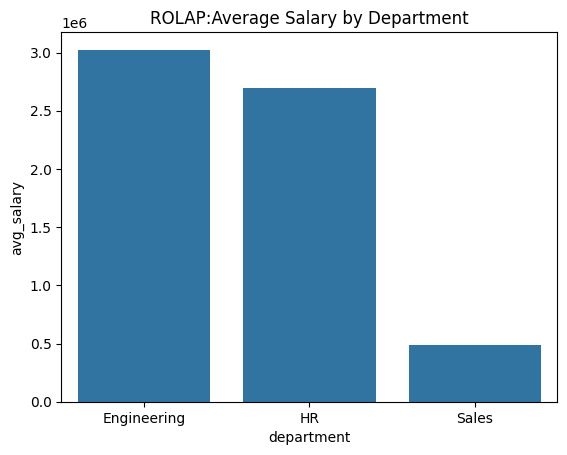

C:\Users\Admin\AppData\Local\Temp\ipykernel_4552\4167937464.py:61: FutureWarning: The provided callable <function mean at 0x0000014508B24680> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  molap_cube = pd.pivot_table(



MOLAP Cube(Department vs Age):
age                 19         21         25       30         31        34
dept_name                                                                 
Engineering  4048344.0  2000000.0        0.0      0.0        0.0       0.0
HR                 0.0        0.0  3928338.0  70000.0  4094805.0       0.0
Sales              0.0        0.0        0.0      0.0        0.0  487504.0


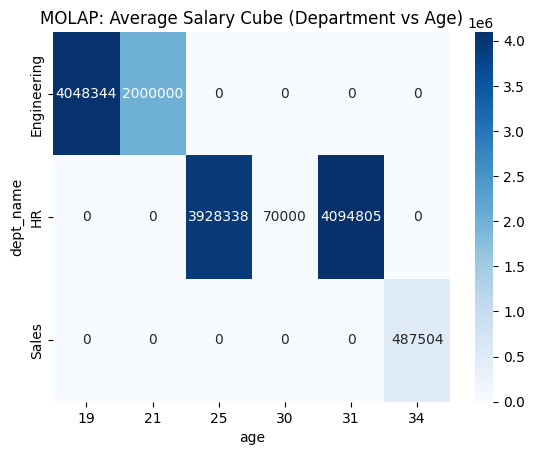


HOLAP Summary (Average Salary by Department):
     dept_name        salary
0  Engineering  3.024172e+06
1           HR  2.697714e+06
2        Sales  4.875040e+05


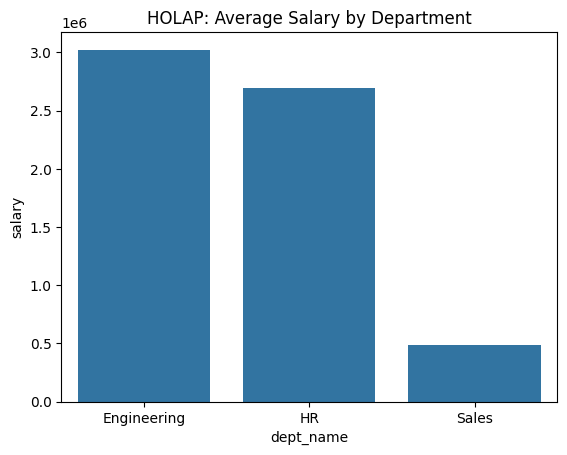


Slice (IT Department):
Empty DataFrame
Columns: [name, dept_name, salary]
Index: []

Dice (HR Department with Salary > 60000):
    name dept_name   salary
0  Alice        HR    70000
2  Steve        HR  3928338
5    Joy        HR  4094805


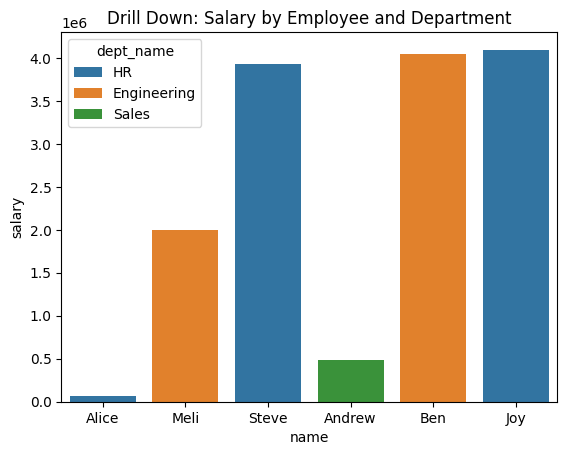


Roll Up (Total Salary by Department):
     dept_name   salary
0  Engineering  6048344
1           HR  8093143
2        Sales   487504


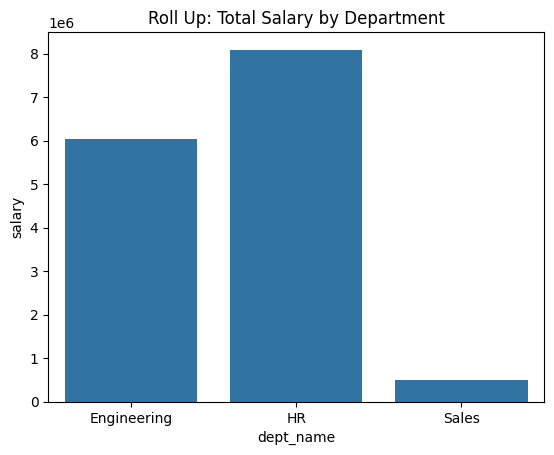

In [13]:
#ROLAP DEMO
#This script demostrates basic ROLAP operations using pandas.

#ROLAP, MOLAP and HOLAP
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt


#database connection
def create_connection(db_file="olap_demo.db"):
    conn = sqlite3.connect(db_file)
    return conn

#ctreate a sample dataset
employees = pd.DataFrame({'emp_id' : [1, 2, 3, 4, 5, 6],
'name' : ['Alice', 'Meli', 'Steve', 'Andrew', 'Ben', 'Joy'],
'age' : [30, 21, 25, 34, 19, 31],
'salary' : [70000, 2000000, 3928338, 487504, 4048344, 4094805],
'dept_id' : [1, 2, 1, 3, 2, 1]
})

departments = pd.DataFrame({
    'dept_id' : [1, 2, 3],
    'dept_name' : ['HR', 'Engineering', 'Sales']
})

#load data into sqlite database
conn=create_connection()
employees.to_sql('employees', conn, if_exists='replace', index=False)
departments.to_sql('departments', conn, if_exists='replace', index=False)

print("Tables created :employees and departments")

#perform OLAP operation


#ROLAP Operations
query="""
SELECT d.dept_name as department, AVG(e.salary) as avg_salary
FROM employees e
JOIN departments d ON e.dept_id = d.dept_id
GROUP BY d.dept_name

"""

rolap_result = pd.read_sql_query(query, conn)
print("\nROLAP RESULT (SQL aggregation):")
print(rolap_result) 

#Visualization rolap by department
sns.barplot(data= rolap_result, x='department', y='avg_salary')
plt.title('ROLAP:Average Salary by Department')
plt.show()

#MOLAP Operation
#Using pandas for in memory aggregation
molap_cube = pd.pivot_table(
    employees.merge(departments, on='dept_id'),
    index='dept_name',
    columns='age',
    values='salary',
    aggfunc=np.mean,
    fill_value=0
)
print("\nMOLAP Cube(Department vs Age):")
print(molap_cube)

#VISUALIZATION :MOLAP cube heatmap
sns.heatmap(molap_cube, annot=True, fmt=".0f", cmap="Blues")
plt.title("MOLAP: Average Salary Cube (Department vs Age)")
plt.show()



#HOLAP Operations
# Combining ROLAP and MOLAP approaches

detail_sql = """
SELECT e.name, d.dept_name, e.salary
FROM employees e
JOIN departments d ON e.dept_id = d.dept_id
"""
detail_df = pd.read_sql_query(detail_sql, conn)
#pandas MOLAP aggregation
holap_summary=detail_df.groupby('dept_name')['salary'].mean().reset_index()

print("\nHOLAP Summary (Average Salary by Department):")
print(holap_summary)

#visualization :HOLAP summary
sns.barplot(data=holap_summary, x='dept_name', y='salary')
plt.title("HOLAP: Average Salary by Department")
plt.show()


#OLAP operations demonstrated: ROLAP, MOLAP, HOLAP

#slice
slice_df=detail_df[detail_df['dept_name']=='IT']
print("\nSlice (IT Department):")
print(slice_df)


#dice
dice_df=detail_df[(detail_df['dept_name']=='HR') & (detail_df['salary']>60000)]
print("\nDice (HR Department with Salary > 60000):")
print(dice_df)

#drill down

sns.barplot(data=detail_df, x='name', y='salary', hue='dept_name')
plt.title("Drill Down: Salary by Employee and Department")
plt.show()



#rollup
rollup_df=detail_df.groupby('dept_name')['salary'].sum().reset_index()
print("\nRoll Up (Total Salary by Department):")
print(rollup_df)

#visualization :rollup
sns.barplot(data=rollup_df, x='dept_name', y='salary')
plt.title("Roll Up: Total Salary by Department")
plt.show()

# Close the database connection
conn.close()